In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display, clear_output

from FewShotTestHandler import FewShotTestHandler, optimize_hyperparameters
from dataset import DatasetHandler
from similarity_metrics import Similarity
from plotting_utils import plot

ENV = os.environ["CONDA_DEFAULT_ENV"]

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
params_dict = {}

# VLM Params - vlm.____ keys are passed into VLM constructor
if ENV == "VLM_CLIP":
    from CLIP.CLIPVLM import ClipVLM as VLM
    params_dict["vlm.num_frames"] = [1] #[1, 2, 4, 10]
elif ENV == "VLM_MILES":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
elif ENV == "videoclip":
    from video_clip.video_clip import VideoClipVLM as VLM
    params_dict["vlm.num_seconds"] = [4] #[2, 4, 10, 16, 32]
    params_dict["vlm.sample_strat"] = ["spread"] #["center", "start", "spread"]
elif ENV == "VLM_UNIVL":
    from UNIVL.wrapper import UniVL_SimilarityVLM as VLM
elif ENV == "VLM_VTTWINS":
    from VTTWINS.wrapper import VTTWINS_SimilarityVLM as VLM
else:
    raise NotImplementedError

# Dataset Params - dataset.____ keys are passed into DatasetHandler constructor
params_dict["dataset.name"] = ["smsm", "moma_act", "moma_sact", "kinetics_100"]
params_dict["dataset.split"] = ["val", "test"]
#params_dict["dataset.class_limit"] = [5]

# Classifier Params - classifier.____ keys are passed into classifier constructor
if True:
    from classifier import WeightedTextFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    #params_dict["classifier.metric"] = [Similarity.COSINE, Similarity.DOT, Similarity.EUCLID]
if False:
    from classifier import HardPromptFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.prompt_text"] = [
        "",
        "a video of",
        "people doing",
        "how to",
        "what is",
        "people are",
        "looks like"
    ]
if False:
    from classifier import NearestNeighborFewShotClassifier as Classifier
    params_dict["classifier.neighbor_count"] = [1, 2, 3, 4, 5, 10, 20]
    params_dict["classifier.neighbor_weights"] = ["uniform", "distance"]
if False:
    from classifier import GaussianFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.prior_count"] = [0, 1, 10, 100]
    params_dict["classifier.prior_var"] = [0, 1, 10, 100]
if False:
    from classifier import SubVideoAverageFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.subvideo_segment_duration"] = [1, 2, 5]
    params_dict["classifier.subvideo_max_segments"] = [32]
    params_dict["classifier.subvideo_discard_proportion"] = [0, 0.1, 0.25, 0.5]

# Few-Shot Test Params - test.____ keys are passed into few-shot test call
params_dict["test.n_way"] = [5, 10, 20]
params_dict["test.n_support"] = [0, 1, 5, 10, 20]
params_dict["test.n_query"] = [1]
params_dict["test.n_episodes"] = [100]

In [3]:
test_handler = FewShotTestHandler("param_test_results.csv")

In [4]:
vlm = None
cur_vlm_params = None
classifier = None
cur_classifier_params = None
dataset = None
cur_dataset_params = None

pbar = tqdm(list(itertools.product(*params_dict.values())))
for params in pbar:
    # Associate keys to each param
    params = dict(zip(params_dict.keys(), params))
    
    pbar.set_postfix(params)
    
    # vlm params
    vlm_params = {key[4:]: val for key, val in params.items() if key.startswith("vlm.")}
    classifier_params = {key[11:]: val for key, val in params.items() if key.startswith("classifier.")}
    dataset_params = {key[8:]: val for key, val in params.items() if key.startswith("dataset.")}
    test_params = {key[5:]: val for key, val in params.items() if key.startswith("test.")}
    
    # Update vlm (which forces update of classifier)
    if vlm is None or cur_vlm_params != vlm_params:
        vlm = VLM(**vlm_params)
        cur_vlm_params = vlm_params
        new_vlm = True
    else:
        new_vlm = False
            
    if new_vlm or classifier is None or cur_classifier_params != classifier_params:
        classifier = Classifier(vlm, **classifier_params)
        cur_classifier_params = classifier_params
        
    # Update dataset (and fill vlm cache for new dataset)
    if new_vlm or dataset is None or cur_dataset_params != dataset_params:
        dataset = DatasetHandler(**dataset_params)
        cur_dataset_params = dataset_params
        dataset.fill_cache(vlm)
        
    # Skip invalid combos of dataset and test parameters
    if not dataset.valid_for_few_shot(test_params["n_way"], test_params["n_support"], test_params["n_query"]):
        continue
    
    # Ensure 0-shot tests always set classifier.text_weight to 1
    if test_params["n_support"] == 0 and "text_weight" in classifier_params:
        classifier_params["text_weight"] = 1.0
    
    # Create classifier for this test (lightweight class, so no need to save over loop iterations)
    classifier = Classifier(vlm, **classifier_params)
    
    # Run test
    test_handler.run_few_shot_test(classifier, dataset, **test_params)
    
clear_output()

### Plot Results

48 Overall Lines
17 Separate Plots


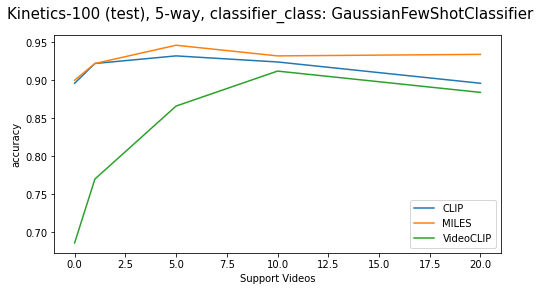

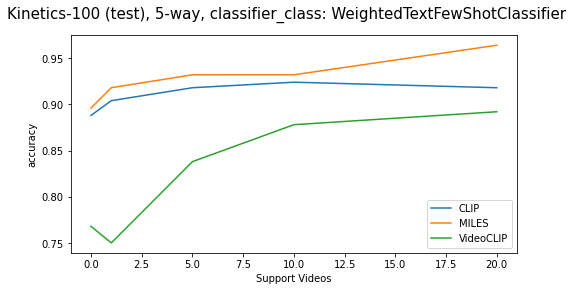

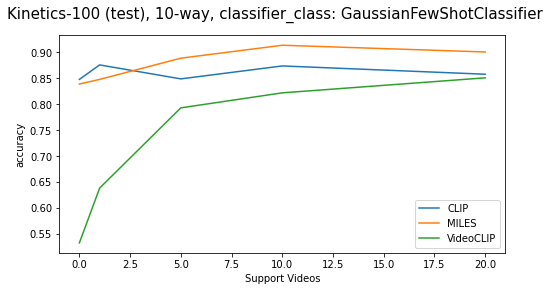

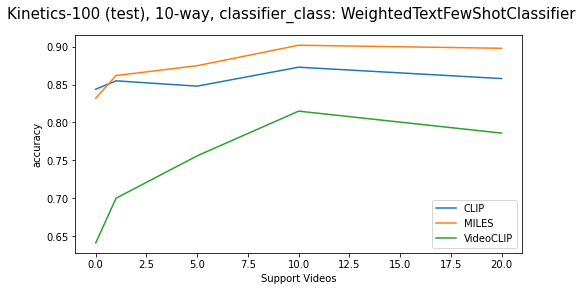

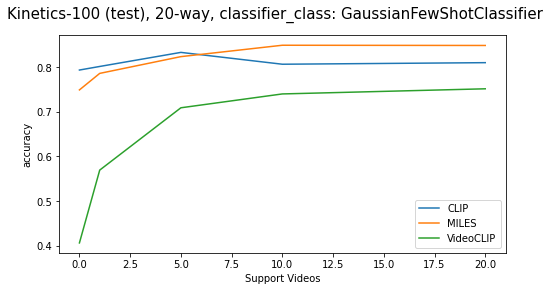

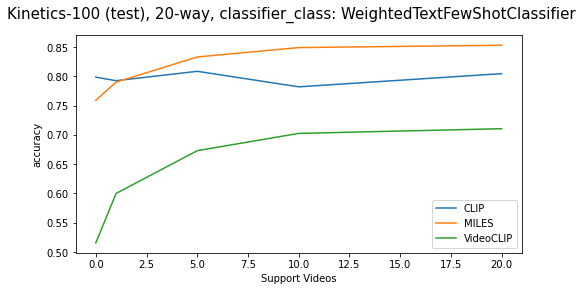

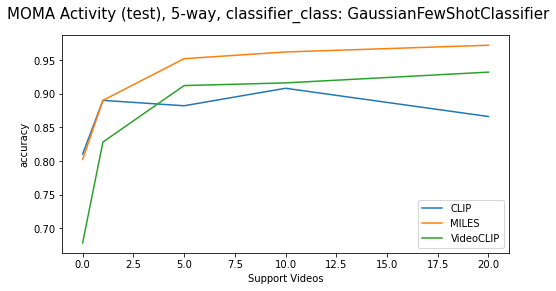

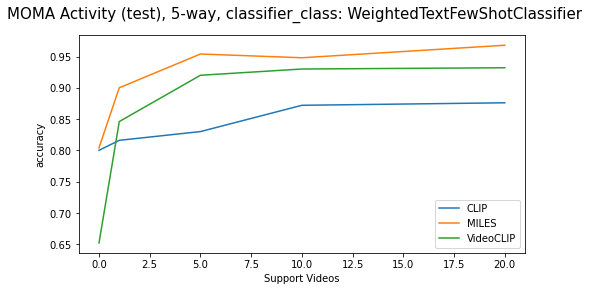

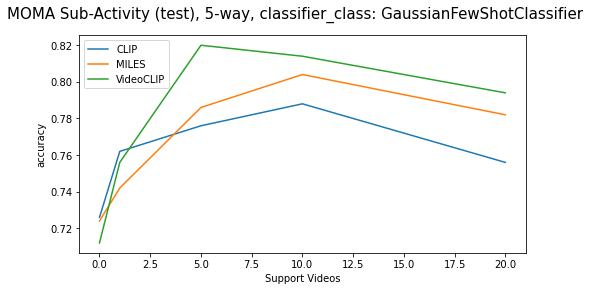

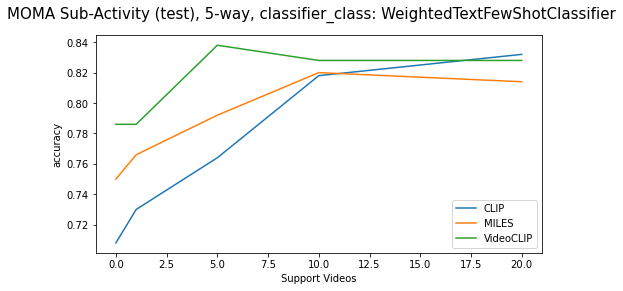

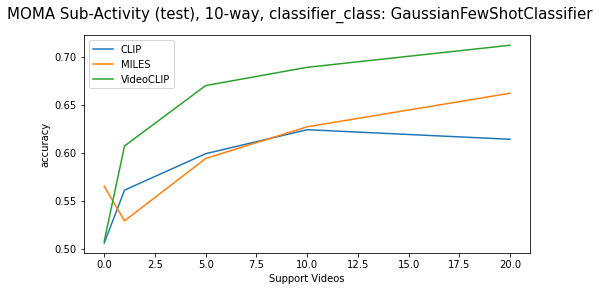

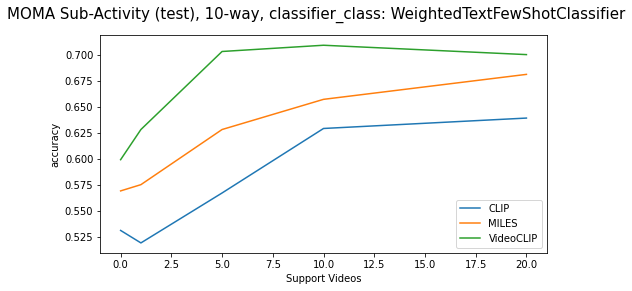

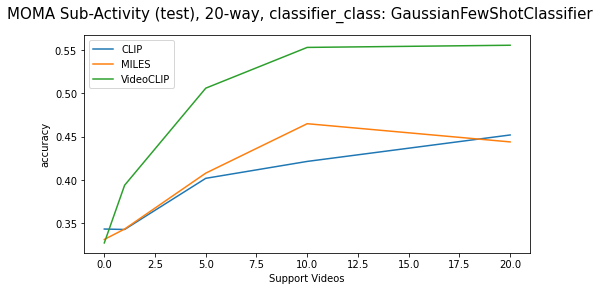

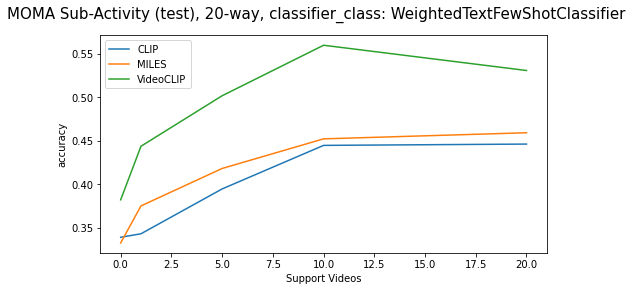

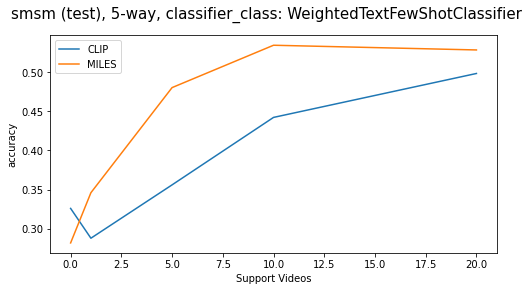

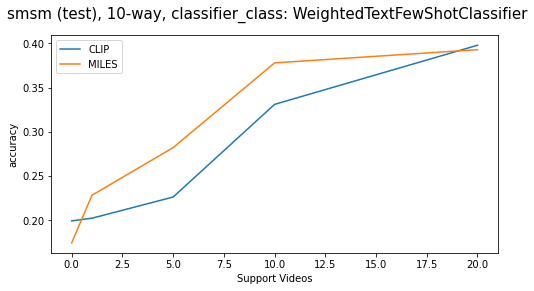

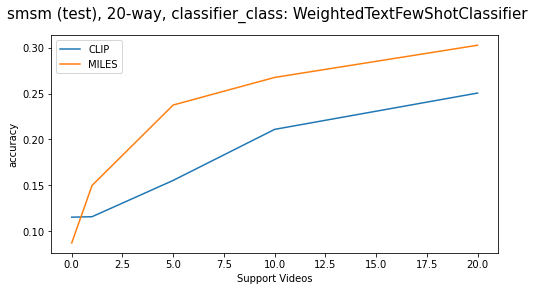

In [5]:
optimized_results = optimize_hyperparameters(
    test_handler.results,
    hyperparam_cols=["classifier.text_weight", "classifier.prior_var", "classifier.prior_count"]
)
plot(
    optimized_results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["dataset", "n_way", "classifier_class"],
    line_descriptor_cols=["vlm_class"]
)